In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt


In [3]:
from PIL import Image
# Open the image
image_path = "Pelican.jpg"  # Replace with your image path
img = Image.open(image_path)

# Convert image to grayscale
grayscale_img = img.convert("L")

# Get pixel values as a 2D array
pixel_table = list(grayscale_img.getdata())
width, height = grayscale_img.size
pixel_table = [pixel_table[i * width:(i + 1) * width] for i in range(height)]

swan_data = pd.DataFrame(pixel_table)
# swan_data = swan_data.to_numpy()

Total capacity of the cuts: 0
Optimal objective value (max flow): -0.0


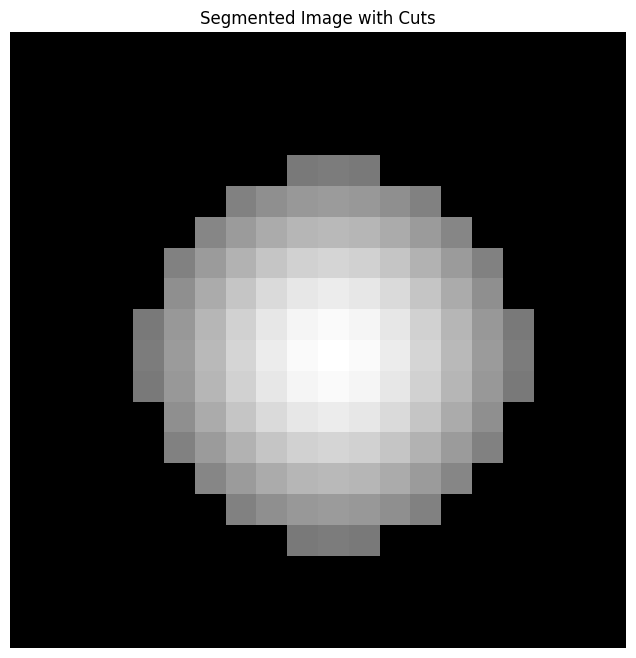

In [5]:

# Step 1: Load the image and set parameters
# ------------------------------------------

# Load the grayscale image from a CSV file into a NumPy array
data = pd.read_csv('oval-1.csv', header=None)
pixel_values = data.to_numpy()

# Specify the background and foreground pixels (row, column)
# Adjust these indices based on your image and desired segmentation
background_pixel = (0, 0)          # Example: top-left corner pixel
foreground_pixel = (20, 20)        # Example: bottom-right corner pixel

# Set sigma for the similarity calculation
sigma = 0.05  # You may need to adjust this value based on your image

# Get the dimensions of the image
rows, cols = pixel_values.shape
num_pixels = rows * cols

# Step 2: Construct the network
# -----------------------------

# Function to calculate similarity between two pixels
def calculate_similarity(I_i, I_j, sigma):
    return np.ceil(100 * np.exp(-((I_i - I_j) ** 2) / (2 * sigma ** 2)))

# Map 2D pixel positions to node indices
def pixel_to_node(r, c):
    return r * cols + c

# Initialize lists to store edges and their capacities
edges = []           # List of tuples: (from_node, to_node)
capacities = []      # Corresponding capacities for the edges

# Variable to keep track of the maximum similarity value
max_similarity = 0

# Loop through each pixel to create edges with its neighbors
for r in range(rows):
    for c in range(cols):
        current_pixel = pixel_to_node(r, c)
        current_intensity = pixel_values[r, c]

        # Consider neighbors: right and below (4-connectivity)
        neighbors = []

        # Right neighbor
        if c + 1 < cols:
            neighbors.append((r, c + 1))

        # Below neighbor
        if r + 1 < rows:
            neighbors.append((r + 1, c))

        # For each neighbor, calculate similarity and add edges
        for nr, nc in neighbors:
            neighbor_pixel = pixel_to_node(nr, nc)
            neighbor_intensity = pixel_values[nr, nc]

            # Calculate similarity
            similarity = calculate_similarity(current_intensity, neighbor_intensity, sigma)

            # Update maximum similarity if necessary
            if similarity > max_similarity:
                max_similarity = similarity

            # Add edges in both directions since the network is undirected
            edges.append((current_pixel, neighbor_pixel))
            capacities.append(similarity)

            edges.append((neighbor_pixel, current_pixel))
            capacities.append(similarity)

# Add source and sink nodes
source_node = num_pixels      # Index for source node
sink_node = num_pixels + 1    # Index for sink node

# Connect source node to the background pixel
bg_pixel_index = pixel_to_node(*background_pixel)
edges.append((source_node, bg_pixel_index))
capacities.append(max_similarity)

# Connect foreground pixel to the sink node
fg_pixel_index = pixel_to_node(*foreground_pixel)
edges.append((fg_pixel_index, sink_node))
capacities.append(max_similarity)

# Total number of nodes (including source and sink)
total_nodes = num_pixels + 2

# Step 3: Formulate the LP using Gurobi
# -------------------------------------

# Initialize the model
model = gp.Model()

# Create a variable for each edge with capacity greater than zero
flow_vars = {}
for idx, (u, v) in enumerate(edges):
    capacity = capacities[idx]
    var_name = f'flow_{u}_{v}'
    flow_vars[(u, v)] = model.addVar(lb=0, ub=capacity, obj=0, name=var_name)

# Set the objective to maximize the flow from the source node
# The flow out of the source node is the flow from source_node to bg_pixel_index
model.setObjective(flow_vars[(source_node, bg_pixel_index)], GRB.MAXIMIZE)

# Add flow conservation constraints for all nodes except source and sink
for node in range(total_nodes):
    if node == source_node or node == sink_node:
        continue  # Skip source and sink nodes

    # Calculate the flow into and out of the current node
    inflow = gp.quicksum(flow_vars[(u, v)] for (u, v) in flow_vars if v == node)
    outflow = gp.quicksum(flow_vars[(u, v)] for (u, v) in flow_vars if u == node)

    # Add the flow conservation constraint
    model.addConstr(inflow == outflow, name=f'FlowConservation_{node}')

# Step 4: Solve the LP
# --------------------
model.Params.OutputFlag = 0 

# Optimize the model
model.optimize()

# Check if an optimal solution was found
if model.status != GRB.OPTIMAL:
    print('No optimal solution found.')
    exit()

# Step 5: Find the min cut from the max flow solution
# ---------------------------------------------------

# Build the residual network
residual_edges = {}
for (u, v), flow_var in flow_vars.items():
    capacity = capacities[edges.index((u, v))]
    flow = flow_var.X  # Corrected line: use flow_var.X to get the solution value
    residual_capacity = capacity - flow

    # If residual capacity is positive, add edge to residual network
    if residual_capacity > 1e-6:  # Threshold to avoid numerical issues
        if u not in residual_edges:
            residual_edges[u] = []
        residual_edges[u].append(v)

# Perform DFS to find all nodes reachable from the source node
def dfs(residual_network, start_node):
    visited = set()
    stack = [start_node]
    while stack:
        node = stack.pop()
        if node not in visited:
            visited.add(node)
            neighbors = residual_network.get(node, [])
            stack.extend(neighbors)
    return visited

# Get the set of nodes reachable from the source node
reachable_nodes = dfs(residual_edges, source_node)

# Identify the cut edges: edges from reachable to non-reachable nodes in the original network
cut_edges = []
for (u, v) in flow_vars:
    if u in reachable_nodes and v not in reachable_nodes:
        # Exclude edges involving source and sink in the cuts
        if u != source_node and v != sink_node:
            cut_edges.append((u, v))

# Calculate the total capacity of the cuts
cut_capacity = sum(capacities[edges.index((u, v))] for (u, v) in cut_edges)

# Verify that the cut capacity equals the maximum flow
print(f'Total capacity of the cuts: {cut_capacity}')
print(f'Optimal objective value (max flow): {model.ObjVal}')

# Step 6: Visualize the results
# -----------------------------

# Plot the original image
plt.figure(figsize=(8, 8))
plt.imshow(pixel_values, cmap='gray', origin='upper')
plt.axis('off')

# Overlay the cuts on the image
for (u, v) in cut_edges:
    # Convert node indices back to (row, column) pixel positions
    row_u, col_u = divmod(u, cols)
    row_v, col_v = divmod(v, cols)

    # Determine the orientation of the cut
    if abs(row_u - row_v) + abs(col_u - col_v) == 1:
        # Adjacent pixels (either horizontal or vertical)
        if row_u == row_v:
            # Vertical edge between pixels (horizontal cut)
            x = (col_u + col_v) / 2
            y = row_u
            plt.plot([x, x], [y - 0.5, y + 0.5], color='red', linewidth=1)
        else:
            # Horizontal edge between pixels (vertical cut)
            x = col_u
            y = (row_u + row_v) / 2
            plt.plot([x - 0.5, x + 0.5], [y, y], color='red', linewidth=1)

# Set plot title
plt.title('Segmented Image with Cuts')
plt.show()